In [1]:
import gmaps
import gmaps.heatmap

import os
import random
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv, find_dotenv
import requests

### Retrieve Google API Key

In [2]:
load_dotenv(find_dotenv())
API_KEY = os.getenv("API_KEY")
gmaps.configure(api_key=API_KEY)

### Utility Functions

The following section provies utility functions to:

* `get_boundaries` Get latitude, longitude boundaries given a centre coordinate and a radius
* `get_grid_points` Get evenly spaced coodinates given lat, lon boundaries and granularity (offset in meters)
* `generate_points` Randomly generate coordinate locations given the boundaries
* `generate_weights` Randomly generate weights for each coordinate location
* `create_heatmap` Render a heatmap given centre, safe places, location hotspots, weights, and max intensity

In [3]:
def get_boundaries(centre, radius=2):
    """
    Given a centre coordinate and specified radius (in km)
    generate a bounding box of lat, lon
    """
    R_EARTH = 6_378
    lat, lon = centre
    
    lat_high = lat  + (radius / R_EARTH) * (180 / math.pi)
    lat_low = lat - (radius / R_EARTH) * (180 / math.pi)
    
    lon_high = lon + (radius / R_EARTH ) * (180 / math.pi) / math.cos(lat * math.pi/180)
    lon_low = lon - (radius / R_EARTH ) * (180 / math.pi) / math.cos(lat * math.pi/180)
    
    return ((lat_low, lat_high), (lon_low, lon_high))

In [4]:
def get_grid_points(boundaries, granularity=20):
    """
    Retrieve an lat, lon coordinates given boundaries and granularity (in meters)
    """
    R_EARTH = 6_378
    
    lat_bound, lon_bound = boundaries
    
    lat_diff = ((granularity / 1000) / R_EARTH) * (180 / math.pi)
        
    start_lat, end_lat = lat_bound
    lat_points = [start_lat]
    while end_lat > start_lat:
        start_lat += lat_diff
        lat_points.append(start_lat)
        
    def get_lon_diff(lat_):
        return ((granularity / 1000) / R_EARTH) * (180 / math.pi) / cos(lat_ * pi/180)
    
    lon_diffs = [get_lon_diff(i) for i in lat_points]
    
    start_lon, end_lon = lon_bound
    lon_points = [start_lon]
    lon_diffs_num = 0
    while end_lon > start_lon:
        start_lon += lon_diffs[lon_diffs_num]
        lon_points.append(start_lon)
        lon_diffs_num += 1
        
    return list(zip(lat_points, lon_points))

In [5]:
def generate_points(boundaries, num_points):
    """
    Randomly generate points given boundaries
    """
    lat_bound, lon_bound = boundaries
        
    return [(random.uniform(*lat_bound), random.uniform(*lon_bound))
            for i in range(num_points)]

In [6]:
def generate_weights(num_points):
    """
    Randomly generate weights
    """
    return [random.random() for i in range(num_points)]

In [7]:
def get_places(location, radius, typ, keyword, open_now=True):
    """
    Retrieve from Google Maps Directions API, nearest location based on type and keyword
    """
    lat, lon = location
    
    req_url = ('https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type={}&keyword={}&opennow={}&key={}'
               .format(lat, lon, radius, typ, keyword, open_now, API_KEY))
    
    response_dict = requests.get(req_url).json()

    nearby_places = [{'name': entry['name'], 'coordinates': entry['geometry']['location']}
                     for entry in response_dict['results'][:10]]
    
    return nearby_places

In [8]:
def create_heatmap(centre, places, locations, weights, max_weight):
    """
    Render heatmap of hotspots with directions to safespots
    """
    fig = gmaps.figure()
    heatmap = gmaps.heatmap_layer(locations, weights)
    symbol_layer = gmaps.symbol_layer(locations)
    places_symbol_layer = gmaps.symbol_layer(places)
    
    symbol_layer.markers = [gmaps.Symbol(location=centre, fill_color='red')]
    places_symbol_layer.markers = [gmaps.Symbol(location=place, fill_color='blue') for place in places]
    
    heatmap.max_intensity = max_weight
    heatmap.point_radius = 25
    
    fig.add_layer(heatmap)
    fig.add_layer(symbol_layer)
    fig.add_layer(places_symbol_layer)
    
    stroke_colors = ['aqua', 'olive', 'yellow', 'lime', 'red', 'black', 'green', 'blue', 'gray', 'fuschia']
    directions = [gmaps.directions_layer(centre,
                                         place, 
                                         stroke_color=stroke_colors[color_idx],
                                         stroke_opacity=0.5,
                                         travel_mode='WALKING')
                  for color_idx, place in enumerate(places)]
    
    for direction in directions:
        fig.add_layer(direction)
    
    return fig

### Sample Run

The following illustrates a trial run:
* Define the centre as `19.069, 72.8777`, the actual centre of Mumbai
* Define a radius of `2 km` around the centre
* Randomly generate 200 coordinates and weights
* Retrieve closest hospitals (safe spot) within a defined radius
* Show directions to each hospital alongside the danger spots on Google Maps

In [9]:
centre = (19.069, 72.8777) # centre of Mumbai
boundaries = get_boundaries(centre=centre)
locations = generate_points(boundaries, 200)
weights = generate_weights(200)

places = get_places(centre, 1000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
create_heatmap(centre, places, locations, weights, 4)

Figure(layout=FigureLayout(height='420px'))

### Mapping Hotspots and Safespots from matrix

The following section details mapping to a sample matrix of Mumbai from `Task 1` with danger levels generated to Google Maps

In [10]:
# define boundaries for Mumbai
D_MIN_LAT = 28.490665
D_MAX_LAT = 28.75683

D_MIN_LON = 77.017121
D_MAX_LON = 77.339847

In [11]:
def create_grid(file_name):
    """
    Read in grid and flatten into 1D array
    """
    grid = []
    with open(file_name) as f:
        for line in f.readlines():
            grid.append(line.rstrip('\n'))
            
    grid = np.array([row.split(',') for row in grid])
    
    return grid.astype(float)

In [12]:
def get_coordinates(lat_min, lat_max, lon_min, lon_max, dimension):
    """
    Get coordinates based on min, max boundaries and resolution (dimension)
    Note: coordinates are not generated according to distance metric, as
    they are evenly spaced lat, lon values based on dimension
    """
    lat_diff = (lat_max - lat_min) / (dimension - 1)
    lon_diff = (lon_max - lon_min) / (dimension - 1)
    
    lat_values = [lat_min + lat_diff * i for i in range(dimension)]
    lon_values = [lon_min + lon_diff * i for i in range(dimension)]
    
    coordinates = [[(j, i) for i in lon_values] for j in lat_values][::-1]
    
    return [j for i in coordinates for j in i]

In [13]:
def rescale(weights):
    """
    Rescale weights to [0, 1] if needed
    """
    return [(i - min(weights)) / (max(weights) - min(weights)) for i in weights]

### Trial run of Heatmapping

Here we test generating a heatmap on Mumbai and check the nearest hospitals to `28.65825037037037, 77.2561772962963` within `2 km`.

In [14]:
locations = get_coordinates(D_MIN_LAT, D_MAX_LAT, D_MIN_LON, D_MAX_LON, 28)
weights = create_grid('sample_grid.csv').flatten()
places = get_places(locations[300], 2000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
create_heatmap(locations[300], places, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

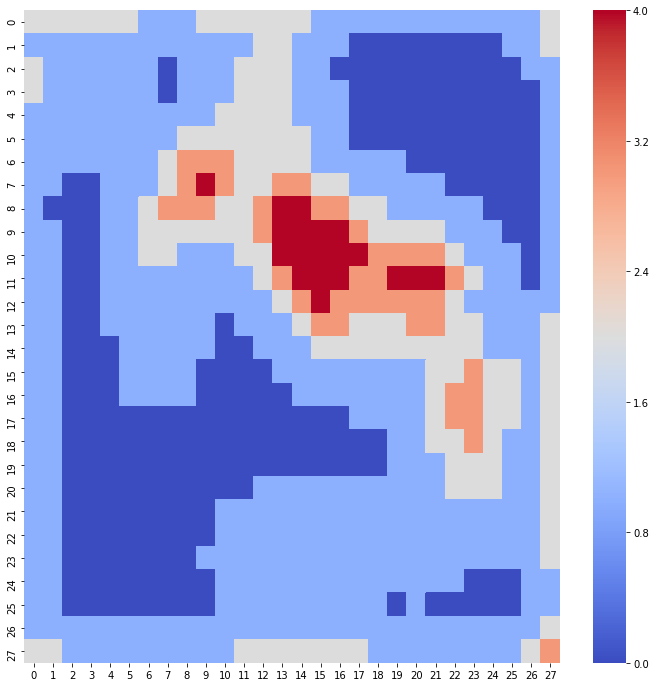

In [15]:
# validate heatmap looks correct using viz library
plt.figure(figsize=(12, 12))
sns.heatmap(create_grid('sample_grid.csv'), cmap='coolwarm')

### Calculation of Safest Route

The following sections details ways to recommend the safest route to a safespot given a lat, lon coordinate.

Below are the various proposed methods:

* **Method 1**: Safest route is determined by safest destination, whichever destination is closest to a coordinate that is the least dangerous

* **Method 2**: Calculation based on weighted average of danger on the 'legs' of routes generated by `Directions API`; each leg has a starting and ending coordinate

* **Method 3**: Calculation based on `Bresenham's line drawing` algorithm; create line segments for each leg of the a route and approximate the gridboxes that each leg segment passes through

#### Method 1: Safest Destination

In [16]:
sample_places = get_places(locations[300], 2000, 'hospital', 'hospital')
sample_places

[{'name': 'Sabharwal Hospital',
  'coordinates': {'lat': 28.6443783, 'lng': 77.2386641}},
 {'name': 'Khadija National Hospital',
  'coordinates': {'lat': 28.6438065, 'lng': 77.2381575}},
 {'name': 'Jag Pravesh Chandra Hospital',
  'coordinates': {'lat': 28.6762461, 'lng': 77.2629156}},
 {'name': 'Jain Charitable Hospital',
  'coordinates': {'lat': 28.6649861, 'lng': 77.2699534}},
 {'name': 'Dehli Hospital',
  'coordinates': {'lat': 28.6417933, 'lng': 77.2450101}},
 {'name': 'Vyas Charitable Hospital',
  'coordinates': {'lat': 28.660889, 'lng': 77.268093}},
 {'name': 'Govind Ballabh Pant Hospital',
  'coordinates': {'lat': 28.6393553, 'lng': 77.23503319999999}},
 {'name': 'Lok Nayak Hospital',
  'coordinates': {'lat': 28.6390815, 'lng': 77.2376888}},
 {'name': 'Lok Nayak Hospital, Gynae Casualty',
  'coordinates': {'lat': 28.6392445, 'lng': 77.23879880000001}},
 {'name': 'RS Grover Hospital',
  'coordinates': {'lat': 28.6426051, 'lng': 77.2774488}}]

In [17]:
create_heatmap(locations[300], [(place['coordinates']['lat'], place['coordinates']['lng']) for place in sample_places], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [18]:
def calc_distance(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

In [19]:
def find_nearest(coordinates, locations):
    """
    Find nearest point given safespot coordinates
    """
    lat, lon = coordinates
    distances = [calc_distance((lat, lon), i) for i in locations]
    
    return np.where(np.array(distances) == np.amin(distances))[0][0]

In [20]:
find_nearest(locations[300], locations)

300

In [21]:
%timeit find_nearest(locations[300], locations)

409 µs ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
def find_best_spot(starting_point, places, danger_weights, locations):
    """
    Given a starting point and list of safe spots and their respective danger weights,
    find the best spot to go
    """
    # calc and update distances
    [place.update({'distance': calc_distance(starting_point,
                                             (place['coordinates']['lat'],
                                              place['coordinates']['lng']))}) for place in places]
    
    # calc weights
    [place.update({'danger_score': danger_weights[
        find_nearest(
            (place['coordinates']['lat'],
             place['coordinates']['lng']), locations)]}) for place in places]
                                                           

    return sorted(places, key=lambda x: (x['danger_score'], x['distance']))[0]

In [23]:
# time to see how efficient
%timeit find_best_spot(locations[300], sample_places, weights, locations)

3.95 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
# best spot based on the 300th starting point
best_spot = find_best_spot(locations[300], sample_places, weights, locations)

In [25]:
best_spot

{'name': 'Jag Pravesh Chandra Hospital',
 'coordinates': {'lat': 28.6762461, 'lng': 77.2629156},
 'distance': 0.01921590543549743,
 'danger_score': 1.0}

In [26]:
# get the best coordinates
best_coordinates = best_spot['coordinates']['lat'], best_spot['coordinates']['lng']

In [27]:
create_heatmap(locations[300], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [28]:
# another example
sample_places = get_places(locations[350], 2000, 'hospital', 'hospital')
sample_places_c = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in sample_places]
create_heatmap(locations[350], sample_places_c, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [29]:
# in this case, the best route is the one furthest from the danger spots
best_spot = find_best_spot(locations[350], sample_places, weights, locations)
best_coordinates = best_spot['coordinates']['lat'], best_spot['coordinates']['lng']
create_heatmap(locations[350], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

#### Method 2: Safest Route based on Weighted `Steps`

In [30]:
def get_route(starting_point, dest_point):
    """
    Get the ending lat, lon steps for each route given starting and destination coordinates
    """
    
    request_url = ('https://maps.googleapis.com/maps/api/directions/'
    + 'json?origin={}&destination={}&mode=walking&key={}').format(','.join(map(str,starting_point)),
                                                                   ','.join(map(str,dest_point)),
                                                                   API_KEY)
    
    response = requests.get(request_url).json()['routes'][0]['legs'][0]

    return_dct = {'total_distance': response['distance']['value']}
    
    return_dct.update({'steps': [{'start': step['start_location'],
                                  'end': step['end_location']} for step in response['steps']]})
    
    return return_dct

In [31]:
def compute_weighted_danger(routes, locations):
    """
    Compute danger for each ending lat, lon coordinate for each route
    """
    steps = [(step['end']['lat'], step['end']['lng']) for step in routes['steps']]
    nearest_coordinates = [find_nearest(step, locations) for step in steps]
    
    return np.mean([weights[idx] for idx in nearest_coordinates])

In [32]:
def sort_routes(routes):
    """
    Return routes list sorted first by danger, then by distance
    """
    [route.update({'danger' : compute_weighted_danger(route, locations)}) for route in routes]
    return sorted(routes, key = lambda x: (x['danger'], x['total_distance']))

In [33]:
places = get_places(locations[350], 2000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
routes = [get_route(locations[350], place) for place in places]

In [34]:
# same example based on location #350 for nearest hospitals
sample_places = get_places(locations[350], 2000, 'hospital', 'hospital')
sample_places_c = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in sample_places]
create_heatmap(locations[350], sample_places_c, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [35]:
# retrieve the top ranked best route
best_route = sort_routes(routes)[0]

# get coordinates of last ending point
best_coordinates = (best_route['steps'][-1]['end']['lat'], best_route['steps'][-1]['end']['lng'])

# show directions on heatmap of best route
create_heatmap(locations[350], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [36]:
# timing Method 2:
%timeit routes = [get_route(locations[350], place) for place in places]
%timeit best_route = sort_routes(routes)[0]

1.62 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40.9 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Method 3: Grid Coverage using Bresenham's Algorithm (from skimage package)

Details for the `Bresenham line drawing algorithm` can be found [here](https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm). 

The general idea behind this algorithm is given a starting endpoint of a line segment, the next grids (or pixels) it traverses to the other endpoint is determined in step-wise fashion by evaluating the midpoint between the each subsequent possible grid points. 

See below for a quick illustration of the idea:

![illustration of algo](https://qph.fs.quoracdn.net/main-qimg-8ebc51acd952f817f96600a78e0856cc)

**Illustration Explained**:

* Here, assume the points actually refer to each pixel for simplicity (the points _are not_ the actual boundaries for a gridbox but the box itself).
* Assume we have a line spanning from left to right in upward slope fashion (smaller `(x, y)` to larger `(x, y)` coordinates). Let's also say that the initial gridbox **`P`** is shaded and has already been determined to be traversed through. 
* Consider point **`P`** has the previous gridbox, we then need to determine the current gridbox to be shaded and for that we need to consider the gridboxes **`E`** and **`NE`** (for _east_ and _northeast_ of the current gridbox, respectively).
* **`M`** is the midpoint between **`E`** and **`NE`**. 
* Based on where the _line_ intersects between **`E`** and **`NE`** and the position of **`M`** relative to that point of intersection (above or below **`M`** ), we can make a decision on the current gridbox that the line traverses through, which is **`NE`** in this case as the line intersects above **`M`**.
* The gridboxes **`E`** and **`NE`** (and consequently, **`M`**) are then updated relative to the current gridbox and the calculations are performed again and again until we reach the end of the line segment

For simipicity, the above demonstration assumes that the line passes through in the `1st octant`, that is - the line has a positive slope of [0, 1]. However the algorithm can be generalized for all magnitude of slopes.

Below is the end output illustration of `Bresenham's algorithm`:
![gridbox shaded](https://qph.fs.quoracdn.net/main-qimg-260a0623b3a83171c463d1377fdc7aa7.webp)

Now we use `skimage` package to draw a line as it implements this algorithm:

In [37]:
from skimage.draw import line

In [38]:
# sample example
example = np.zeros((10, 10))
example

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
# specify coordinates for line
x0, y0 = 1,1
x1, y1 = 7,9
rr, cc = line(y0, x0, y1, x1)
example[rr, cc] = 1
example

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

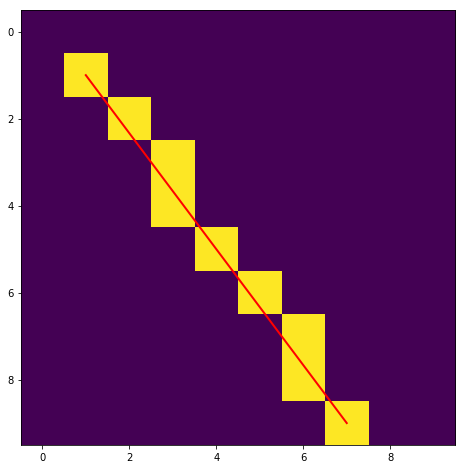

In [40]:
# plot the shaded gridbox, notice how note all gridboxes passed are shaded
plt.figure(figsize=(8,8))
plt.imshow(example, interpolation='nearest', cmap='viridis')
plt.plot([x0, x1],[y0, y1], linewidth = 2, color = 'r', )

In [41]:
# show directions on heatmap of best route
start_coordinates = locations[350]
start_location = 350
end_coordinates = 28.608534444444446, 77.11446040740741
create_heatmap(locations[350], [start_coordinates, end_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [42]:
end_location = find_nearest((end_coordinates), locations)
x0, y0 = start_location % 28, start_location // 28
x1, y1 = end_location % 28, end_location // 28

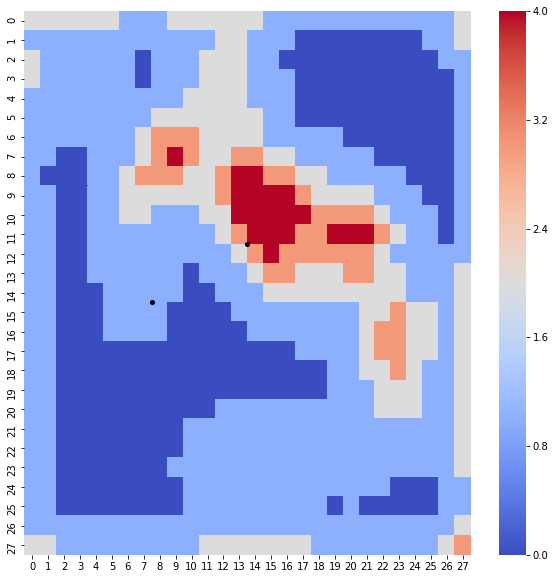

In [43]:
# plot start & end points
plt.figure(figsize=(10,10))
sns.heatmap(weights.reshape(28,28), cmap='coolwarm')
plt.plot([x0, x1], [y0, y1], 'ko', markersize=4)

In [44]:
route_bresenham = get_route(start_coordinates, end_coordinates)['steps']
steps_bresenham = [find_nearest((step['end']['lat'], step['end']['lng']), locations) for step in route_bresenham]
steps_bresenham.insert(0, start_location) # ensure starting point is in steps

In [45]:
# set operation is unordered, retain the same order from before
interpolated_routes = sorted(set(steps_bresenham),key=steps_bresenham.index)

In [46]:
# map from 1D to 2D
x_ = [i % 28 for i in interpolated_routes]
y_ = [i // 28 for i in interpolated_routes]

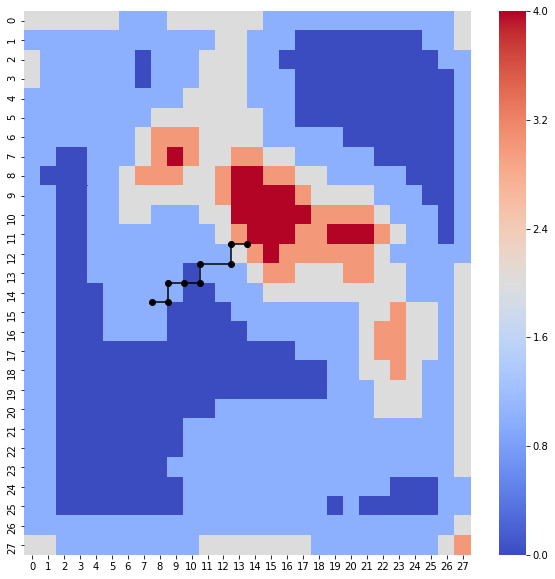

In [47]:
# plot start & end points
plt.figure(figsize=(10,10))
sns.heatmap(weights.reshape(28,28), cmap='coolwarm')
plt.plot(x_, y_, 'ko-')

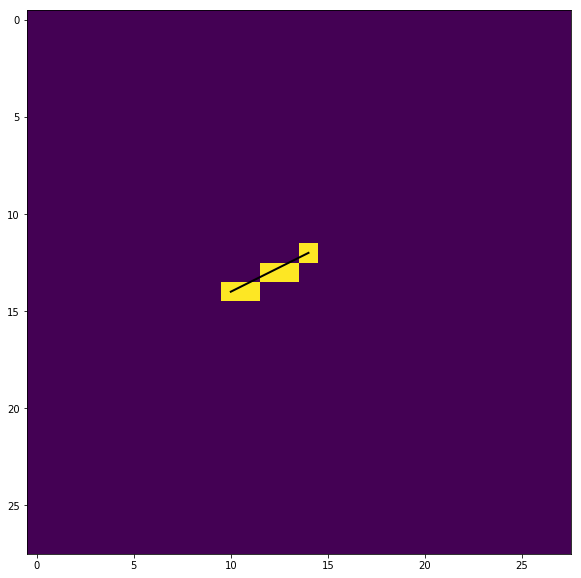

In [48]:
# works better wheach step spans more than 1 gridbox 
# as each gridbox is ~920m - rare to have each step longer than that
arr = np.zeros((28, 28))
rr, cc = line(y_[0], x_[0], y_[5], x_[5])
arr[rr, cc] = 1
plt.figure(figsize=(10, 10))
plt.imshow(arr)
plt.plot([x_[0], x_[5]], [y_[0], y_[5]] , linewidth=2, color='black')

#### Method 4: `supercover`

This method is an extension of the `Bresenham's line drawing` algorithm and has full gridbox coverage:

In [49]:
def supercover(y0, x0, y1, x1):
    """
    Supercover algorithm
    """
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    starting_x = x0
    starting_y = y0
    
    step = 0
    total_change = dx + dy
    err = dx - dy
    x_inc = 1
    y_inc = 1
    
    max_length = (max(dx, dy) + 1) * 3
    rr = np.zeros(max_length)
    cc = np.zeros(max_length)
    
    if x1 > x0:
        x_inc = 1
    else:
        x_inc = -1
    
    if y1 > y0:
        y_inc = 1
    else:
        x_inc = -1
        
    dx = 2 * dx
    dy = 2 * dy
    
    while total_change > 0:
        rr[step] = starting_y
        cc[step] = starting_x
        step += 1
        if (err > 0):
            starting_x += x_inc
            err -= dy
        elif (err < 0):
            starting_y += y_inc
            err += dx
        else: # corner edge case
            rr[step] = starting_y + y_inc
            cc[step] = staring_x
            rr[step + 1] = starting_y
            cc[step + 1] = starting_x + x_inc
            step = step + 2
            
            starting_x += x_inc
            starting_y += y_inc
            
            err = err + dx - dy
            
            total_change = total_change - 1
        total_change = total_change - 1 
    rr[step] = starting_y
    cc[step] = starting_x
        
    return np.array(rr[:step + 1]).astype(int), np.array(cc[:step + 1]).astype(int)
    

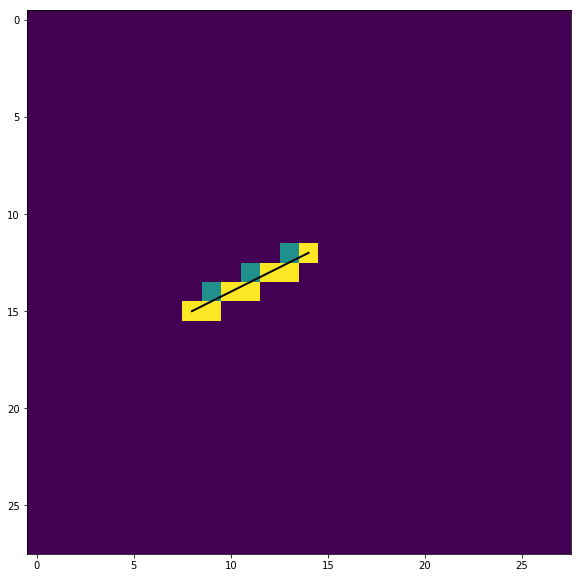

In [50]:
# green boxes are the covered boxes not completed by Bresenham
arr = np.zeros((28, 28))
rr, cc = line(y_[0], x_[0], y_[8], x_[8])
rr1, cc1 = supercover(y_[0], x_[0], y_[8], x_[8])
arr[rr, cc] = 1
arr[rr1, cc1] += 1
plt.figure(figsize=(10, 10))
plt.imshow(arr)
plt.plot([x_[0], x_[8]], [y_[0], y_[8]] , linewidth=2, color='black')